In [1]:
# 대조발산 사용해서 이미지를 생성 -> 로그분포의 그레이디언트를 직접 추정해서 모델을 학습
# 원시데이터에 여러 스케일의 잡음을 적용 NCSN(noise conditional score network)
# 2020년에 논문-->확산모델
# GAN에 필적할 만한 모델 DDPM(denoising diffusion probabilitics model)


In [2]:
# 원본
# https://www.kaggle.com/datasets/nunenuh/pytorch-challange-flower-dataset

# 구글드라이브 공유
# https://drive.google.com/file/d/1jrATCAQQaYTu0dzUOruC2ZZWQ-BeY9Ig/view?usp=sharing

# 소스코드 위치
# https://keras.io/examples/generative/ddpm/

In [ ]:
!unzip '/content/drive/MyDrive/Oxford 102 Flower Dataset/Oxford 102 Flower Dataset.zip'

In [4]:
from glob import glob
imglists = glob('/content/dataset/**/*')
imglists_sample = glob('/content/dataset/test/*.jpg')
imglists_sample[:5]

['/content/dataset/test/image_04277.jpg',
 '/content/dataset/test/image_01599.jpg',
 '/content/dataset/test/image_03048.jpg',
 '/content/dataset/test/image_06351.jpg',
 '/content/dataset/test/image_07434.jpg']

In [9]:
from myutils import display, sample_batch

In [ ]:
import matplotlib.pylab as plt
import matplotlib.image as mpimg
image = mpimg.imread(imglists_sample[0])
plt.imshow(image)

잡음제거  확산모델
  - 연속해서 매우 조금씩 이미지에서 잡을을 제거하도록 모델을 훈련
  - 데이터셋에서 정방향(잡음추가)과 역방향(잡음제거)확산과정

In [10]:
from tensorflow.keras import utils

In [15]:
train_data = utils.image_dataset_from_directory(
    '/content/dataset/',
    labels=None,
    image_size=(64,64),
    batch_size = None,
    shuffle=True,
    seed=42,
)

Found 8189 files belonging to 1 classes.


In [16]:
import tensorflow as tf

In [17]:
# 데이터 전처리
def preprocess(img):
  img = tf.cast(img,'float32') / 255.0
  return img

In [ ]:
train = train_data.map(lambda x : preprocess(x))  # 픽셀값을 0과 1사이로 조정
train = train.repeat(5)  # 데이터를 5번 반복
train = train.batch(64,drop_remainder=True)  # 배치로 데이터를 나눌때 64보다 작을때 남는데이터 무시

In [ ]:
# 이미지를 여러단계에 걸처서(T1000번) 점진적으로 손상시켜서 가우스 표준잡음과 구별할수 없도록 만든다.
# 이미지에 분산 bi를 갖는 소량의 가우스 잡음을 추가해서 새로운 이미지를 생성하는 함수 q를 정의 이 함수를 계속적용

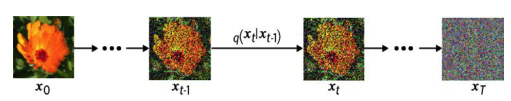

In [18]:
# 각 스텝마다 다른 bi를 자유롭게 선택 bi값이 T에 따라 변하는 방식을 확산스케줄
# 논문에서는 선형확산스케줄  bi가 0.0001 ~ 0.02까지 선형적으로 변환다
# 잡음 추가과정의 초기단계에서 후기단계보다 잡음이 적게 추가

In [34]:
# 확산스케줄
def linear_diffusion_schedule(diffusion_times):  # diffusion_times 확산단계의 수
  min_rate = 0.0001
  max_rate = 0.02
  # 각 단계에서 확산 속도를 계산 min_rate에서 시작해서 max_rate로 선형적으로 증가
  betas = min_rate + tf.convert_to_tensor(diffusion_times) * (max_rate - min_rate)
  alphas = 1-betas # betas의 역수   가 단계에서의 신호 속도
  alpha_bars = tf.math.cumprod(alphas) # alphas의 누적 곱, 간 단계에서 전체 누적신호 속도
  signal_rates = tf.sqrt(alpha_bars)
  noise_rates = tf.sqrt(1-alpha_bars) # 각 단계에서의 noise 속도
  return noise_rates,signal_rates

In [ ]:
# 코사인 확산 스케줄 : 선형스케줄보다 성능이 우수
# 삼각 함수 항등식  코사인제곱 + 사인제곱 = 1

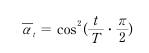

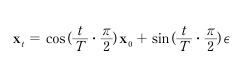

In [30]:
# 코사인 확산 스케줄, 오프셋 코사인 확산 스케줄
# 확산과정 초기에 잡음 추가가 너무 적게 되지 않도록 오프셋 항과 스케일링을 추가해서 구현
import math
def cosine_deffusion_schedule(diffusion_times):
  diffusion_times = tf.convert_to_tensor(diffusion_times)
  signal_rates = tf.cos(diffusion_times*math.pi / 2)
  noise_rates = tf.sin(diffusion_times*math.pi / 2)
  return noise_rates,signal_rates

def offset_cosine_diffusion_schedule(diffusion_times):
  min_signal_rate = 0.02
  max_signal_rate = 0.95
  start_angle = tf.acos(max_signal_rate) # 각도
  end_angle=tf.acos(min_signal_rate) # 각도
  diffusion_angles = start_angle + diffusion_times*(end_angle - start_angle)
  signal_rates = tf.cos(diffusion_angles)
  noise_rates = tf.sin(diffusion_angles)
  return noise_rates, signal_rates

In [35]:
T = 1000
diffusion_times = [x/T for x in range(T)]  # 확산 시간은 0과 1 사이에서 동일한 간격으로 나눈 값
linear_noise_rates, linear_signal_rates =  linear_diffusion_schedule(diffusion_times)
cosine_noise_rates,cosine_signal_rates = cosine_deffusion_schedule(diffusion_times)
offset_cosine_noise_rates, offset_cosine_signal_rates = offset_cosine_diffusion_schedule(diffusion_times)

In [36]:
# 신호와 잡음이 만들어지는과정을 시각화
# 신호

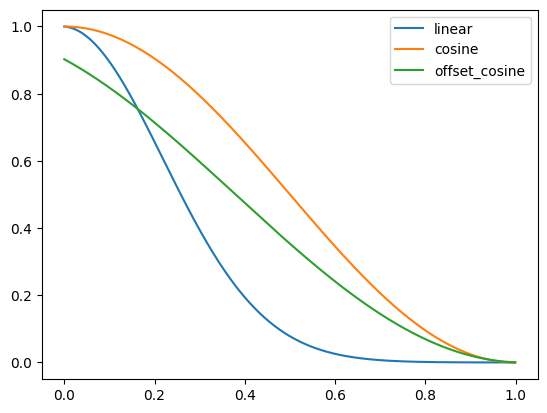

In [40]:
import matplotlib.pyplot as plt
plt.plot(diffusion_times,linear_signal_rates**2,label='linear')
plt.plot(diffusion_times,cosine_signal_rates**2,label='cosine')
plt.plot(diffusion_times,offset_cosine_signal_rates**2,label='offset_cosine')
plt.legend()
# plt.axis('off')
plt.show()

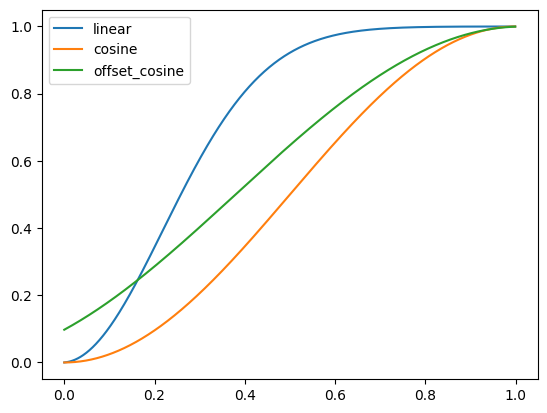

In [41]:
plt.plot(diffusion_times,linear_noise_rates**2,label='linear')
plt.plot(diffusion_times,cosine_noise_rates**2,label='cosine')
plt.plot(diffusion_times,offset_cosine_noise_rates**2,label='offset_cosine')
plt.legend()
# plt.axis('off')
plt.show()

In [42]:
# 코사인 확산 스케줄에서는 잡음 레벨이 더 느리게 상승, 코사인 확산 스케줄은 선형 확산스케줄보다 이미지에 잡음을 더 점진적으로 추가 품질 향상

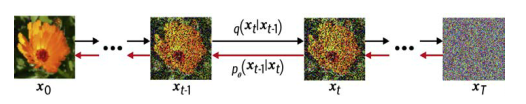

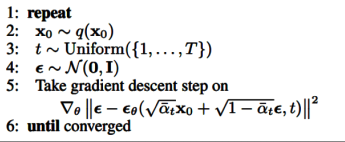

In [43]:
IMAGE_SIZE = 64
BATCH_SIZE = 64
DATASET_REPETITIONS = 5
LOAD_MODEL = False

NOISE_EMBEDDING_SIZE = 32
PLOT_DIFFUSION_STEPS = 20

# 최적화
EMA = 0.999
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 50

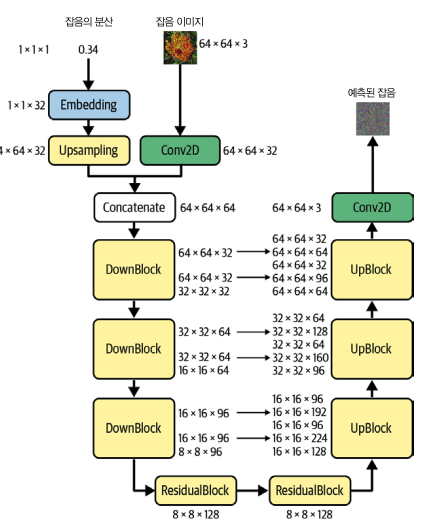

In [46]:
import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    optimizers,
    utils,
    callbacks,
    metrics,
    losses,
    activations,
)

In [47]:
from tensorflow.keras import layers
def sinusoidal_embedding(x):
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(1.0),
            tf.math.log(1000.0),
            NOISE_EMBEDDING_SIZE // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply

# U-Net 구축

noisy_images = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = layers.Conv2D(32, kernel_size=1)(noisy_images)

noise_variances = layers.Input(shape=(1, 1, 1))
noise_embedding = layers.Lambda(sinusoidal_embedding)(noise_variances)
noise_embedding = layers.UpSampling2D(size=IMAGE_SIZE, interpolation="nearest")(
    noise_embedding
)

x = layers.Concatenate()([x, noise_embedding])

skips = []

x = DownBlock(32, block_depth=2)([x, skips])
x = DownBlock(64, block_depth=2)([x, skips])
x = DownBlock(96, block_depth=2)([x, skips])

x = ResidualBlock(128)(x)
x = ResidualBlock(128)(x)

x = UpBlock(96, block_depth=2)([x, skips])
x = UpBlock(64, block_depth=2)([x, skips])
x = UpBlock(32, block_depth=2)([x, skips])

x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

unet = models.Model([noisy_images, noise_variances], x, name="unet")

In [ ]:
from tensorflow.keras import models, layers
class DiffusionModel(models.Model):
    def __init__(self):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = unet
        self.ema_network = models.clone_model(self.network)
        self.diffusion_schedule = offset_cosine_diffusion_schedule

    def compile(self, **kwargs):
        super().compile(**kwargs)
        self.noise_loss_tracker = metrics.Mean(name="n_loss")

    @property
    def metrics(self):
        return [self.noise_loss_tracker]

    def denormalize(self, images):
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        if training:
            network = self.network
        else:
            network = self.ema_network
        pred_noises = network(
            [noisy_images, noise_rates**2], training=training
        )
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps
        current_images = initial_noise
        for step in range(diffusion_steps):
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                current_images, noise_rates, signal_rates, training=False
            )
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            current_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
        return pred_images

    def generate(self, num_images, diffusion_steps, initial_noise=None):
        if initial_noise is None:
            initial_noise = tf.random.normal(
                shape=(num_images, IMAGE_SIZE, IMAGE_SIZE, 3)
            )
        generated_images = self.reverse_diffusion(
            initial_noise, diffusion_steps
        )
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        images = self.normalizer(images, training=True)  # 이미지 배치를 평균이 0이고 단위분을 갖도록 정규화
        noises = tf.random.normal(shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)) #입력 이미지의 크기에 맞게 잡음을 샘플링

        diffusion_times = tf.random.uniform(
            shape=(BATCH_SIZE, 1, 1, 1), minval=0.0, maxval=1.0
        ) #확산시간도 샘플링
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times) # 코사인 확산 스케줄에 따라서 잡음과 신호 비율을 생성

        noisy_images = signal_rates * images + noise_rates * noises # 잡음 이미지를  생성

        with tf.GradientTape() as tape:
            # 잡음 이미지에서 잡음을 구분하도록 훈련합니다.
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            ) # noise_rates, signal_rates 를 이용해서 잡음을 예측하고 잡음을 제거

            noise_loss = self.loss(noises, pred_noises)  # 평균 절대값 오차

        gradients = tape.gradient(noise_loss, self.network.trainable_weights) # 손실함수에대한 경사하강법 수행
        self.optimizer.apply_gradients(
            zip(gradients, self.network.trainable_weights)
        )

        self.noise_loss_tracker.update_state(noise_loss)

        for weight, ema_weight in zip(
            self.network.weights, self.ema_network.weights
        ):
            ema_weight.assign(EMA * ema_weight + (1 - EMA) * weight) # 경사하강법 다음에 기존 가중치와 훈련된 가중치의 평균을 사용해서
            # EMA 신경망의 가중치를 업데이트

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))
        diffusion_times = tf.random.uniform(
            shape=(BATCH_SIZE, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        noisy_images = signal_rates * images + noise_rates * noises
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )
        noise_loss = self.loss(noises, pred_noises)
        self.noise_loss_tracker.update_state(noise_loss)

        return {m.name: m.result() for m in self.metrics}